In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

transactions = pd.read_csv('transactions_train_data.csv', index_col = 0)
transactions = transactions.drop(['t_dat', 'price', 'sales_channel_id'], axis = 1)
train_data, test_data = train_test_split(transactions, test_size = .3, random_state = 1)

In [2]:
def build_dataset(data):
    '''function to reconstruct original dataframe into a dictionary
        dictionary layout:
        {customer id : set([article id, article id, article id, ...])'''
    
    dic = {}
    
    for i in data.iterrows():
        customer_id, article_id = i[1]
       
        if customer_id in dic:
            dic[customer_id].add(article_id)
        else:
            dic[customer_id] = set()
            dic[customer_id].add(article_id)
    return dic

In [3]:
#initiate the dataset into a dictionary
train_data = build_dataset(train_data)

In [4]:
def build_matrix(data, k_list):
    '''function to construct a binary matrix of k list of similar customers
        index = customer id
        column = articles'''
    
    articles = set()
    matrix_dict = {}
    #retrieve all unique article id given k list of similiar customers to the target
    for i in k_list:
        for j in data[i]:
            articles.add(j)
    
    #reconstruct into a binary matrix 1 = have purchased, 0 = have not
    for i in k_list:
        i_list = data[i]
        k_matrix = []
        for a in articles:
            if a in i_list:
                k_matrix.append(1)
            else:
                k_matrix.append(0)
        
        matrix_dict[i] = k_matrix
    
    matrix = pd.DataFrame.from_dict(matrix_dict, orient='index')
    matrix.columns = list(articles)
    return matrix


In [5]:
def cosine_similarity(list1, list2):
    '''function to return the cosine similarity score of two list'''
    
    #reconstruct given two list into two new equal length list
    set_list = set()
    set_list = set_list.union(list1, list2)
    new_1 = []
    new_2 = []
    
    for i in set_list:
        if i in list1:
            new_1.append(1)
        else:
            new_1.append(0)
        
        if i in list2:
            new_2.append(1)
        else:
            new_2.append(0)
    
    #cosine similarity formula
    cosine = np.dot(new_1, new_2)/ (np.linalg.norm(new_1) * np.linalg.norm(new_2))
    return cosine

In [6]:
def mean_score(matrix):
    '''function return mean score of a matrix by row
        customer id : total number of purchased / total items in the matrix'''
    
    return matrix.mean(axis = 1)

In [7]:
def get_knn(train_data, customer, K):
    '''function return the K number customers' mean score and similarity score close to the targert customer
        customer id : similarity, mean'''
    
    #get customer purchase profile from train dataset
    customer = train_data[customer]
    
    #similarity score
    corr_list = []
    #customer id
    sim_list = []
    #iterate over entire dataset to find all customers' similarity score
    for i in train_data:
        Y = train_data[i]
        if Y is not customer:
            similarity = cosine_similarity(customer, Y)
            corr_list.append(similarity)
            sim_list.append(i)
    
    #construct dataframe based of the similarity score
    result = pd.DataFrame()
    result['similarity'] = corr_list
    result.index = sim_list
    #sort similarity score by descending order
    result = result.sort_values(by = ['similarity'], ascending = False)
    #get top K number of customer
    result = result.iloc[0:K]
    #filter out negative top K number of customers
    result = result[result['similarity'] > 0]
    #get the mean score of the remaining K number of customers
    matrix = build_matrix(train_data, list(result.index))
    result['mean'] = mean_score(matrix)
    return result

In [32]:
def append_article(train_data, customer_id, article_id):
    '''function to manually modify and add new purchases to a customer'''
    
    train_data[customer_id].add(article_id)
    
    return train_data
    

In [33]:
def remove_article(train_data, customer_id, article_id):
    '''function to manually modify and remove purchases from a customer'''
    train_data[customer_id].remove(article_id)
    
    return train_data

In [36]:
def predict(train_data, customer_id, K, recommend_num):
    '''function predict and return a list of top recommended items'''
    
    #get target customer purchasing profile
    customer = train_data[customer_id]
    #find K number of customers similiar to target customer
    result = get_knn(train_data, customer_id, K)
    #get similar customers' customer id
    knn_customers = []
    for i in list(result.index):
        knn_customers.append(i)
    #using the list of similiar customers' id to create the matrix
    knn_matrix = build_matrix(train_data, knn_customers)

    #drop articles that target customer have already purchased 
    for i in customer:
        if i in list(knn_matrix.columns):
            knn_matrix = knn_matrix.drop([i], axis = 1)
    
    # iterate by matrix's column and subtract similar customers' mean score
    # and multiply by its similarity score
    for i in knn_matrix.iteritems():
        knn_matrix[i[0]] = i[1] - result['mean']
        knn_matrix[i[0]] = i[1] * result['similarity']
    
    
    #sum of absolute item score and sort by descending order
    recommended_items = knn_matrix.sum().sort_values(ascending=False)
    #return the highest item score article id by recommended number
    return list(recommended_items.index)[:recommend_num]

In [9]:
def predict_error(train_data, test_data, K, recommend_num):
    '''function return the hits accuracy'''
      
    hits = 0
    attempts = 0
    #compile the test data into a dictionary
    test_data = build_dataset(test_data)
    
    
    for i in test_data:
        customer_id = i
        article_id = test_data[i]
        #get recommended items
        pred = predict(train_data, customer_id, K, recommend_num)
        
        #one prediction is equal one attempt
        attempts += 1
        #if the target customer's later purchases were in the recommended list
        #hits + 1
        for j in article_id:
            if j in pred:
                hits += 1

      
    return hits / attempts

In [43]:
demo_customer_id = '990e58645b49ec6b0c0069900d86b6d243ce21744e33502de86a74521c682c68'

#demo for function get_knn
get_knn(train_data, demo_customer_id, 5)

,similarity,mean
2707700c614496d8af2ce10f7c9a295367f5c95ccbfff14b9076865ebbc8be62,0.333333,0.146341
2ddbfc293dc1ca2776ef595ab2cb90d3ddf88734641121d17387f6b58f6c7d2f,0.308607,0.170732
ba29755b3de1ab95a235dc0c9dfade64920156a836fec89d1126523574091cf3,0.235702,0.073171
1ca787f98bd3da4bab0f694209e69dc35cfef9769954300e9bf61c445ebe7439,0.210819,0.365854
afcbc713086d2d6b2fdf0fd2d680158cf22677f42a7a011793cb68d702043c06,0.198030,0.414634


In [35]:
#demo for adding and removing articles from a customer
print('Demo customer current purchase list:',train_data[demo_customer_id])

#adding new articles
append_article(train_data, demo_customer_id, 111111111)
print('Demo customer updated purchase list:',train_data[demo_customer_id])

#removing articles
remove_article(train_data, demo_customer_id, 111111111)
print('Demo customer updated purchase list:',train_data[demo_customer_id])

Demo customer current purchase list: {691446002, 160442010, 764147001, 724399002, 575347003, 160442043}
Demo customer updated purchase list: {111111111, 691446002, 160442010, 764147001, 724399002, 575347003, 160442043}
Demo customer updated purchase list: {691446002, 160442010, 764147001, 724399002, 575347003, 160442043}


In [16]:
#demo for predict function
predict(train_data, demo_customer_id, 50, 12)

[160442007,
 372860001,
 372860002,
 670752001,
 508184020,
 539197012,
 658841001,
 678861001,
 728162002,
 728162001,
 690980004,
 751592001]

In [17]:
predict_error(train_data, test_data, 50, 12)

0.09906617945594803

In [10]:
#find the best K value given the dataset
x = []
y = []

#default recommend 12 items 
for i in range(10, 105, 5):
    accuracy = predict_error(train_data, test_data, i, 12)
    y.append(accuracy)
    x.append(i)

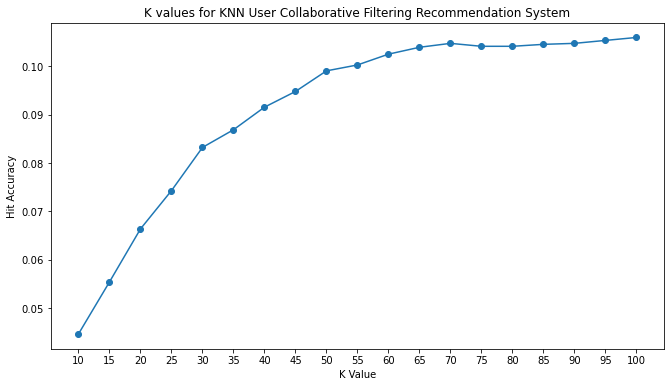

In [14]:
plt.figure(figsize = (11,6))
plt.xticks(x)
plt.xlabel('K Value')
plt.ylabel('Hit Accuracy')
plt.title('K values for KNN User Collaborative Filtering Recommendation System')
plt.plot(x,y, '-o')
plt.show()